In [1]:
import numpy as np
import cv2
from imutils import paths
import sys
sys.path.append("../src/")
import config

In [2]:
import matplotlib.pyplot as plt

In [3]:
data = config.DATA
imagePaths = list(paths.list_images(data))
imgPath1 = imagePaths[0]
imgPath2 = imagePaths[1]

In [4]:
img1 = cv2.cvtColor(cv2.imread(imgPath1), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(imgPath2), cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(cv2.imread("./best_pairs/10L.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("./best_pairs/10R.jpg"), cv2.COLOR_BGR2RGB)
img1 = cv2.resize(img1, (640, 480))
img2 = cv2.resize(img2, (640, 480))


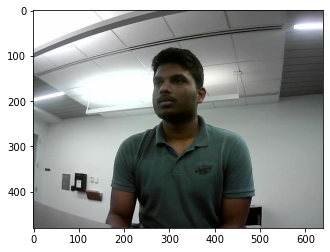

In [5]:
plt.imshow(img1)
plt.show()

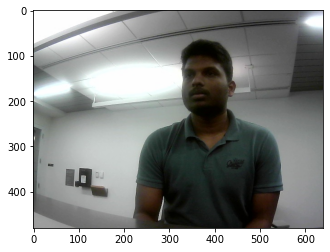

In [6]:
plt.imshow(img2)
plt.show()

In [7]:
sift = cv2.xfeatures2d.SIFT_create()

In [8]:
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

In [9]:
print(len(keypoints_1))
print(len(keypoints_2))
print(len(descriptors_1))
print(len(descriptors_2))

254
170
254
170


In [10]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

In [11]:
matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

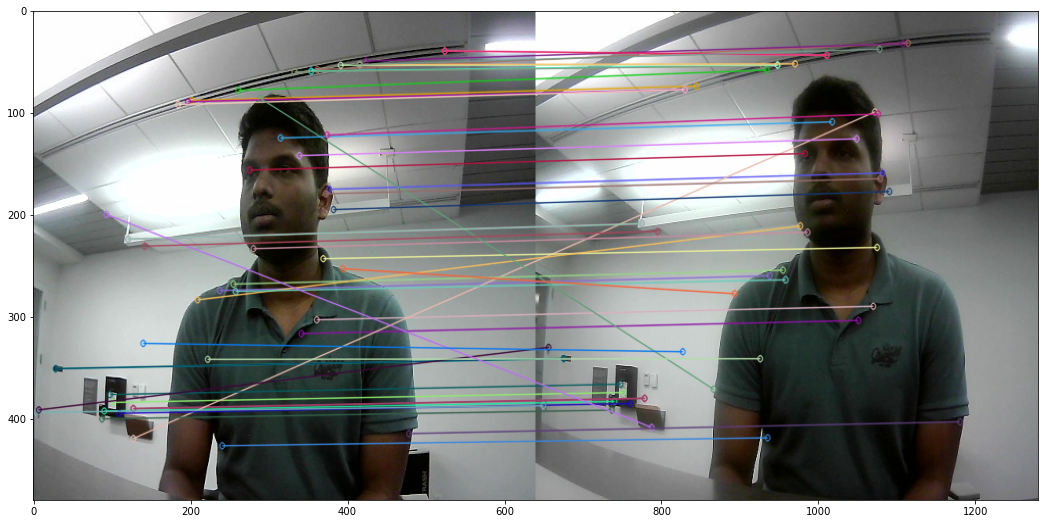

(<matplotlib.image.AxesImage at 0x15b3424f6d0>, None)

In [12]:
img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
fig, ax = plt.subplots(figsize=(18, 9))
ax.imshow(img3, aspect="auto"),plt.show()

In [13]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)

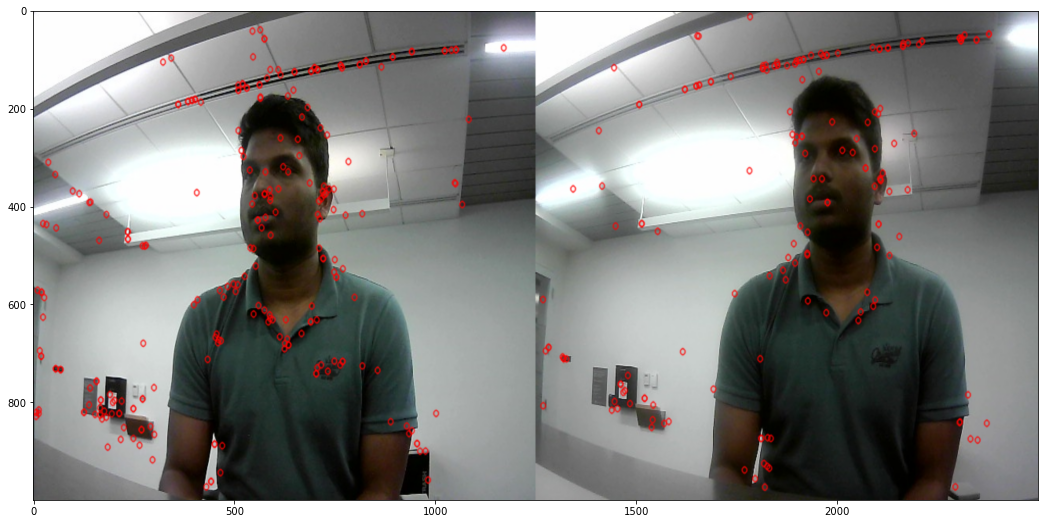

(<matplotlib.image.AxesImage at 0x15b3424fa00>, None)

In [14]:
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.80*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(keypoints_2[m.trainIdx].pt)
        pts1.append(keypoints_1[m.queryIdx].pt)


# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    img1, keypoints_1, img2, keypoints_2, matches[300:500], None, **draw_params)
keypoint_matches = cv2.resize(keypoint_matches, (2500,1000))
fig, ax = plt.subplots(figsize=(18, 9))
ax.imshow(keypoint_matches, aspect="auto"),plt.show()

In [15]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [16]:
F

array([[ 2.48366891e-07, -5.55811066e-05,  1.08153795e-02],
       [ 6.79018856e-05, -1.26118430e-06,  5.42669181e-02],
       [-1.20327397e-02, -5.53510767e-02,  1.00000000e+00]])

In [17]:
import cv2 as cv

In [18]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

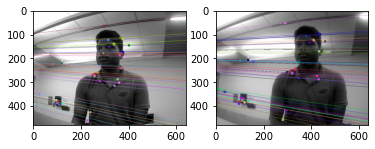

In [19]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [20]:
img1.shape

(480, 640)

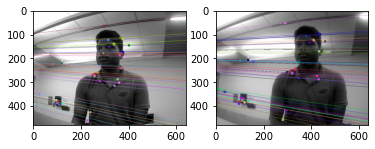

In [21]:
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

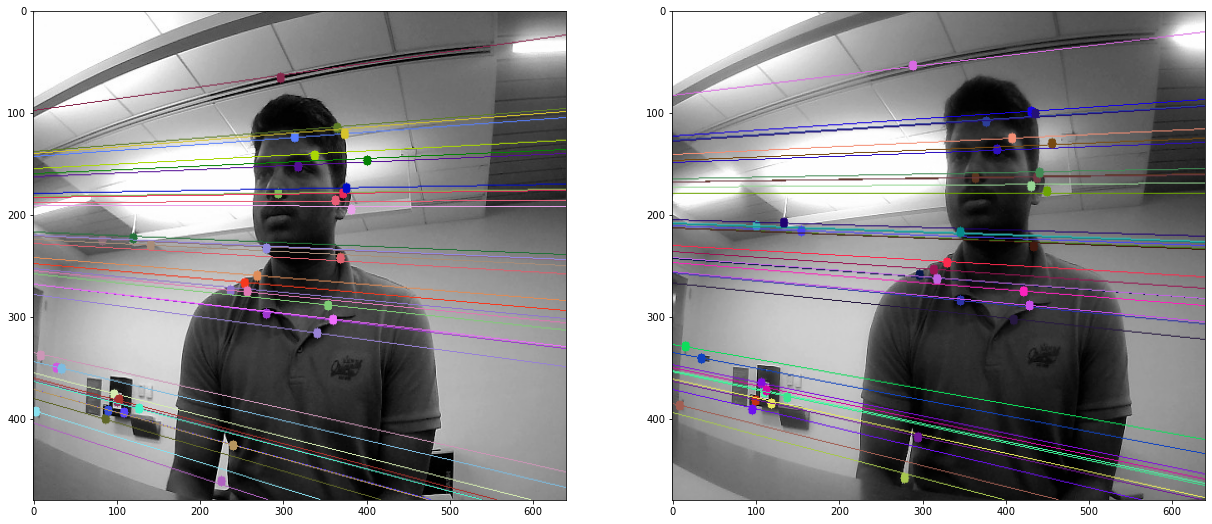

(<matplotlib.image.AxesImage at 0x15b3436ad60>, None)

In [22]:
fig, ax = plt.subplots(1,2,figsize=(21, 9))
ax[0].imshow(img5, aspect="auto")
ax[1].imshow(img3, aspect="auto"),plt.show()

In [23]:
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1)
)

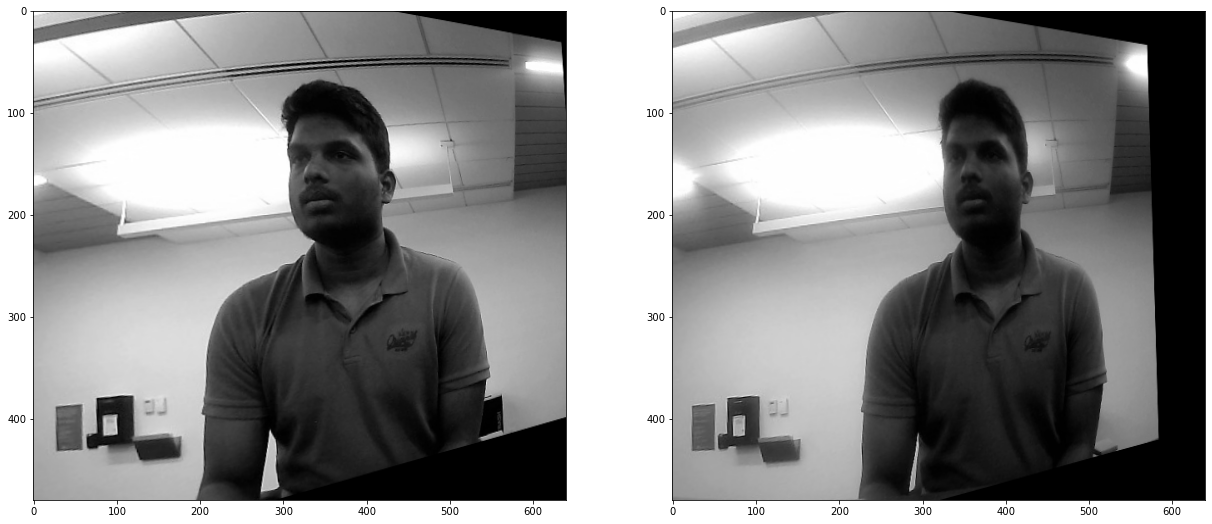

(<matplotlib.image.AxesImage at 0x15b34441040>, None)

In [24]:
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))
fig, ax = plt.subplots(1,2,figsize=(21, 9))
imr1 = cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2RGB)
imr2 = cv2.cvtColor(img2_rectified, cv2.COLOR_BGR2RGB)
ax[0].imshow(imr1, aspect="auto")
ax[1].imshow(imr2, aspect="auto"),plt.show()

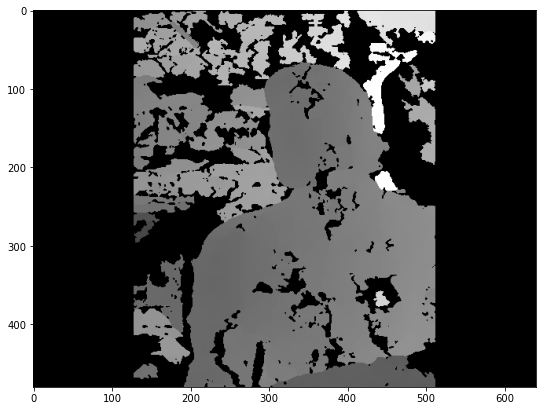

(<matplotlib.image.AxesImage at 0x15b34241190>, None)

In [25]:
block_size = 11
min_disp = -128
max_disp = 128
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 200
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 2
disp12MaxDiff = 0

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)
disparity_SGBM = stereo.compute(img1_rectified, img2_rectified)

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)
fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(disparity_SGBM, 'gray'),plt.show()

In [26]:
F

array([[ 2.48366891e-07, -5.55811066e-05,  1.08153795e-02],
       [ 6.79018856e-05, -1.26118430e-06,  5.42669181e-02],
       [-1.20327397e-02, -5.53510767e-02,  1.00000000e+00]])

In [28]:
np.save("H1.npy",H1)
np.save("H2.npy",H2)